# Notebook to compute relative errors in the accelerations computed with Gadget and BFE

## TODO

- Look at the acceleration for a particlar particle
- How does the acceleration error changes with the epxansion length
- What about centering ? 

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('/mnt/home/nico/matplotlib.mplstyle')
from matplotlib.colors import LogNorm
import linecache
import sys

# Astropy 

from astropy.constants import Constant
import astropy.constants as const
import astropy.units as u
import numpy as np

#G_unit = u.m**3 / u.kg / u.s**2
#astropy.constants.G = Constant(
#    'G', 
#    'Gravitational constant',
#    (43007.1 * u.kpc * u.km**2 / u.s**2 / u.Msun / 1E10 ).to_value(G_unit),
#    'm3 / (kg s2)',
#    np.nan, 
#    system='si',
#    reference='GADGET'
#)





# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic
from gala.potential.scf import compute_coeffs_discrete, SCFPotential

# Third party
sys.path.append("../../BFE_integrator/src/")
sys.path.append("../../bfe_gala_orbits/notebooks/")

from orbit_gala_script import get_center
from read_coefficients import load_scf_coefficients


import nba
from nba.ios import load_halo
from nba.ios import load_snapshot
from nba.com.com_routines import shrinking_sphere

import pynbody
from bfe.ios import read_coefficients

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pynbody.analysis.halo import shrink_sphere_center as ssc

In [3]:
# const.G
# 43007.1 * (u.kpc * u.km**2 / u.s**2 / u.Msun / 1E10 ).to_value(u.m**3 / u.kg / u.s**2)

In [4]:
## 
def load_coefficients(coeff_path, coeff_name, centers_path, snap_params, exp_length, exp_params):
    
    
    # Snapshots parameters
    dt = snap_params[0] #0.02
    init_snap = snap_params[1] #500
    final_snap = snap_params[2]
    nsnaps_nbody = final_snap - init_snap + 1
    
    # Coefficients parameters
    nmax = exp_length[0] # 15
    lmax = exp_length[1] #5
    mmax = exp_length[2] #5
    
    # Expansion parameters 
    rs_halo = exp_params[0] #20
    pm =  exp_params[1] #  2.334E-4 #/ 0.999 # particle mass in N-body sims
    sn_cut = exp_params[2] # 5
    
    
    #n_orbits = 730 # in the N-body file
    #HR = 100.0
    #p_orbit = 1 # Which orbit to use from the N-body code  
    #t_orbit = np.arange(0, nsnaps_nbody*dt, dt)
    #t_orbit2 = np.arange(0, nsnaps_nbody*dt, dt/HR)
   
    #coeff_path_centers = '/mnt/home/nico/projects/bfe_computation/examples/runing_pipeline/BFE_LMC5_grav_MO5_ss_COM_n15_l5_host_snap'
    #path_to_coeff = "../../../projects/bfe_computation/examples/runing_pipeline/"
    #coeff_file = "BFE_LMC5_grav_MO5_ss_COM_n15_l5_host_snap_"
    
    S_scf = np.zeros((nsnaps_nbody, nmax+1, lmax+1, mmax+1))
    T_scf = np.zeros((nsnaps_nbody, nmax+1, lmax+1, mmax+1))

    rcom_all = np.zeros((int(nsnaps_nbody), 3))
    vcom_all = np.zeros((int(nsnaps_nbody), 3))
    
    i = 0
    for i in range(init_snap, final_snap):
        rcom_all[i], vcom_all[i] = get_center(coeff_path_centers+'_{:03d}.txt'.format(i))
        S_scf[i], T_scf[i] = load_scf_coefficients(path_to_coeff + coeff_file + "{:03d}.txt".format(i), nmax, lmax, mmax, pm, sn=sn_cut)
        i+=1
    return S_scf, T_scf

In [5]:
def acceleration_diff(d, a1, a2, figname, da_limits, ylabel):
    """
    returns a1-a2  / a2
    """
    a_dif = np.sqrt(np.sum((a1-a2)**2, axis=1))/ np.sqrt(np.sum(a2**2, axis=1))
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    h  = np.histogram2d(np.log10(d), a_dif, bins=100)
    im = ax.imshow(h[0].T, cmap='bone_r', norm=LogNorm(), origin='lower', 
                   aspect='auto', extent=[np.min(np.log10(d)), np.max(np.log10(d)), np.min(a_dif), np.max(a_dif)])
    fig.colorbar(im)
    ax.set_ylim(da_limits[0], da_limits[1])
    ax.set_xscale('log')
    ax.set_xlabel(r'$r\rm{[kpc]}$')
    ax.set_ylabel(ylabel)
    savefig(figname, bbox_inches='tight')
    return a_dif

In [6]:
# Forcetest_file 

def get_direct_acceleration(file_path, N_lines, sample_lines=1000000, skip_footer=True):
    #file_path = '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'
    #N_lines = 63229293 
    if skip_footer == True:
        force_test = np.genfromtxt(file_path, skip_header=0, skip_footer=N_lines - sample_lines)
    else:
        force_test = np.genfromtxt(file_path, skip_header=0)
    time = force_test[:,3]
    pos = force_test[:,4:7]
    a_direct = force_test[:,8:11]
    a_fmm = force_test[:,11:14]
    #dist = np.sqrt(np.sum(pos**2, axis=1))
    del(force_test)
    return time, pos, a_direct, a_fmm

In [7]:
!wc -l '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'

^C


In [20]:
!head -1 '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'


1 0 4362261 0      7.26451826096    -4.33303308487      7.6756749153      104.237640386     -497.514736346     295.093281131    -524.619867643     -497.512357596     295.128648952    -524.588138953     -24614.8395351     -24614.610143


## 1. Direct acceleration vs FMM vs BFE

### Isolated halo 

In [7]:
# Simulations isolated halo acccelerations
acceleration_file = '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'
time_a, pos_a, a_direct, a_fmm = get_direct_acceleration(acceleration_file, N_lines=63229293)

a_direct_mag = np.sqrt(np.sum(a_direct**2, axis=1))
a_fmm_mag = np.sqrt(np.sum(a_fmm**2, axis=1))
dist = np.sqrt(np.sum(pos_a**2, axis=1))
dcut = np.where((dist>5) & (dist<500))

In [8]:
#!wc -l '/mnt/home/nico/ceph/HQ_iso_halo/iso_softening_100pc_grav_MO3/forcetest.txt'

In [9]:
#! head -1000000 /mnt/home/nico/ceph/MWLMC_sims/ICs/MW/MO3/forcetest.txt > mw_MO3_forcetest.txt

In [10]:
path_to_coeff = "/mnt/home/nico/projects/bfe_computation/examples/runing_pipeline/BFE_LMC5_grav_MO3_ssc_COM_n20_20_host_snap_000"

coeff_iso, exp_length, snap_params, iso_rcom = read_coefficients(path_to_coeff)
S_scf_iso = coeff_iso[0]
T_scf_iso = coeff_iso[1]

<KeysViewHDF5 ['G', 'Snlm', 'Tnlm', 'lmax', 'mmax', 'nmax', 'pmass', 'rcom', 'rs']>
* Loading coefficients


In [14]:
np.shape(S_scf_iso)

(21, 21, 21)

In [ ]:
S_scf_iso

In [15]:
## Isolated halo 
halo = gp.scf.SCFPotential(m=1e10*u.Msun, r_s=snap_params[0]*u.kpc, Snlm=S_scf_iso, Tnlm=T_scf_iso, units=galactic)


In [22]:
np.shape(pos_a[dcut])

(899754, 3)

In [24]:
a_bfe = halo.acceleration(pos_a[dcut].T).to(u.kpc/u.Gyr**2).value

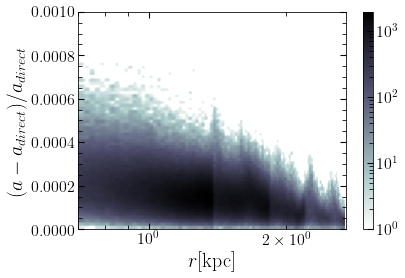

In [16]:
a_dif_direct_fmm = acceleration_diff(dist[dcut], a_direct[dcut], a_fmm[dcut], 'gadget_acc_errors.png', [0, 1E-3])


In [ ]:
a_dif_direct_bfe = acceleration_diff(dist[dcut], a_direct[dcut], a_bfe.T, 'BFE_acc_errors.png', [0, 0.1],
                                     '$a_{BFE} /a_{direct} - 1$')

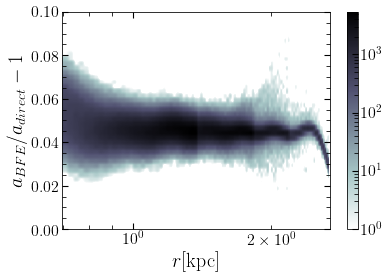

In [26]:
a_dif_direct_bfe = acceleration_diff(dist[dcut], a_direct[dcut], a_bfe.T, 'BFE_acc_errors_n20_l20.png', [0, 0.1],
                                     '$a_{BFE} /a_{direct} - 1$')

## Isolated MW halo 


In [20]:
# Simulations isolated MW acccelerations


#acceleration_file_mw = '/mnt/home/nico/ceph/MWLMC_sims/ICs/MW/MO3/forcetest.txt'
acceleration_file_mw = 'mw_MO3_forcetest.txt'

time_mw_a, pos_mw_a, a_mw_direct, a_mw_fmm = get_direct_acceleration(acceleration_file_mw, N_lines=1000000, skip_footer=False)

a_mw_direct_mag = np.sqrt(np.sum(a_mw_direct**2, axis=1))
a_mw_fmm_mag = np.sqrt(np.sum(a_mw_fmm**2, axis=1))
dist_mw = np.sqrt(np.sum(pos_mw_a**2, axis=1))
dcut_mw = np.where((dist_mw>5) & (dist_mw<500))

In [21]:
path_to_coeff = "/mnt/home/nico/projects/bfe_computation/examples/MW_MO3_coefficients/BFE_MW_grav_MO3_ssc_COM_host_snap_000"

coeff_mw, mw_exp_length, mw_snap_params, mw_rcom = read_coefficients(path_to_coeff)
S_scf_mw = coeff_mw[0]
T_scf_mw = coeff_mw[1]

<KeysViewHDF5 ['G', 'Snlm', 'Tnlm', 'lmax', 'mmax', 'nmax', 'pmass', 'rcom', 'rs']>
* Loading coefficients


In [28]:
mw_potential = gp.CCompositePotential()
rs_halo = mw_snap_params[0]
print(rs_halo)
#mw_potential.G = 4.498768e-6  #kpc^3/(Msun Gyr**2)
#mw_potential['bulge'] = gp.HernquistPotential(m=1.4E10*u.Msun, c=0.7*u.kpc, units=galactic)
#mw_potential['disk'] = gp.MiyamotoNagaiPotential(m=5.78E10*u.Msun, a=2.4*u.kpc, b=0.5*u.kpc,units=galactic)
mw_potential['halo'] = gp.scf.SCFPotential(m=1e10*u.Msun, r_s=rs_halo*u.kpc, Snlm=S_scf_mw, Tnlm=T_scf_mw, units=galactic)





40.85


In [40]:
mw_potential.G = 43007.1 * u.kpc * u.km**2 / u.s**2 / u.Msun / 1E10 

In [41]:
mw_a_bfe = mw_potential.acceleration(pos_mw_a[dcut_mw].T).to(u.kpc/u.Gyr**2).value


## TODO: Fix x-label axis

# Make this plot also at time 2 Gyrs

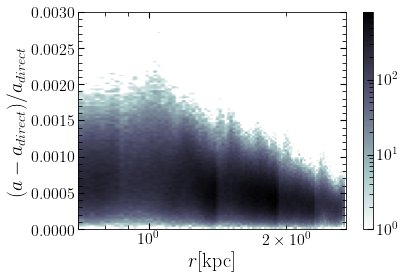

In [24]:
# 

a_dif_direct_fmm_mw = acceleration_diff(dist_mw[dcut_mw], a_mw_direct[dcut_mw], a_mw_fmm[dcut_mw], 'gadget_mw_acc_errors.png', [0, 3E-3])


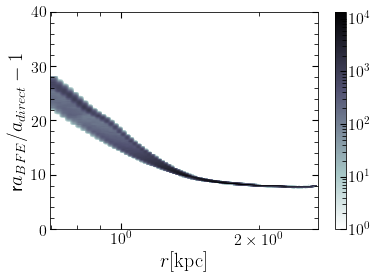

In [42]:
a_dif_direct_bfe_mw = acceleration_diff(dist_mw[dcut_mw], a_mw_direct[dcut_mw], mw_a_bfe.T, 
                                        'gadget_mw_bfe_acc_errors.png', [0, 40], 'r$a_{BFE} /a_{direct} - 1$')


In [ ]:
# Read coefficients

In [32]:
np.shape(mw_a_bfe.T)

(100000, 3)

In [ ]:
#a_dif_direct_bfe_mw = acceleration_diff(dist_mw[dcut_mw], a_direct_mw[dcut_mw], a_bfe_.T[dcut], 'BFE_acc_errors.png', [0, 0.1])

In [ ]:
# Coefficients evolution 